## Monte Carlo simulation of muon lifetime lab
Take N muons and randomly assign them a random lifetime picked from an exponential distribution\
Create a histogram of the results in 16384 channels, mimicking the Ortec 927 MCA\
Plot the raw histogram\
Take the log of the number of counts and replot\
Fit the curve (unweighted)\
Fit the curve (weighted via sigmas = 1/sqrt(N))

We'd like to generate a random lifetime for an individual muon that gets stopped in the bucket, with the expectation that the probability of decaying follows an exponential distribution, which runs from 0 all the way to infinity.  Here is an efficient technique for generating such random numbers.

### Generating Exponentially Distributed Lifetimes

We start with the assumption that individual lifetimes are distributed randomly, but proportional to the distribution $e^{-kt}.$ If we make a histogram of individual lifetimes, we would develop a curve that was a decreasing exponential with a decay constant of $k$. We can also say that the probability of any given muon having a life between t and t + ∆t is proportional to the integral

$\int_{t}^{t+\Delta t}e^{-kt}dt$.


First, show that the normalized probability distribution (one whose integral over the full range of interest from zero to infinity is one) is given by

$P(t) = ke^{-kx}$.

The idea now is to stretch out the random number generator [0..1] so it will match this exponential distribution. For example, we would like to convert any random number in the lower half of the generator range (i.e., $t_{1/2}$, with 50:50 odds) defined implicitly by the relationship

$\int_{0}^{t_{1/2}}ke^{-kt}dt = \frac{1}{2},$

into its corresponding probability under the exponential distribution, which will contain a greater fractional probability than 50 %.  First, solve this for $t_{1/2}$.








Now that you have the general idea, convince yourself that the way to stretch your random numbers into the correct probability distribution is to start with a random number RND generated uniformly in the range from zero to one, and convert it into an individual random lifetime $t_r$:

$\int_{0}^{t_{r}}ke^{-kt}dt = $ RND.


Rearrange this expression for our $P(t)$ to find $t_r$ explicitly in terms of RND.

You should find that $t_r$ = -$\frac{1}{k}\ln({1-\rm{RND})}$





I have written this last expression in a way that allows us to use it for any probability distribution we wish to mimic. Sometimes we end up with an expression that is difficult to invert, or we have a function that we don't know how to integrate. If this is the case, we can always take the route of creating a rough table of the cumulative integral numerically. We can then use some of the interpolation techniques we learned early in the course to interpolate these values to find the correct value to associate with a generated random number. This may also be quicker than trying to evaluate a complicated analytical expression with a lot of transcendental functions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Let's test out the effectiveness of our formula by generating some random numbers with a decay constant of 1/700

100000


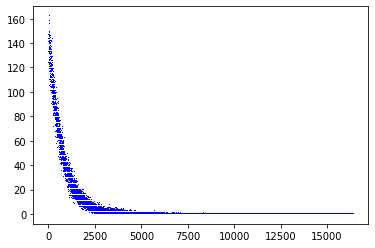

2320


C:\Users\alexh\AppData\Local\Temp/ipykernel_6292/3881129347.py:14: RuntimeWarning: divide by zero encountered in log
  logHist = np.log(hist)  # this will produce some -inf when the values go to 0


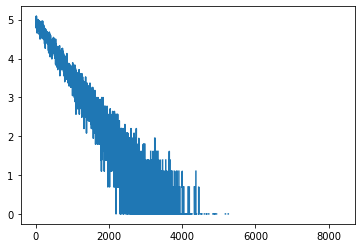

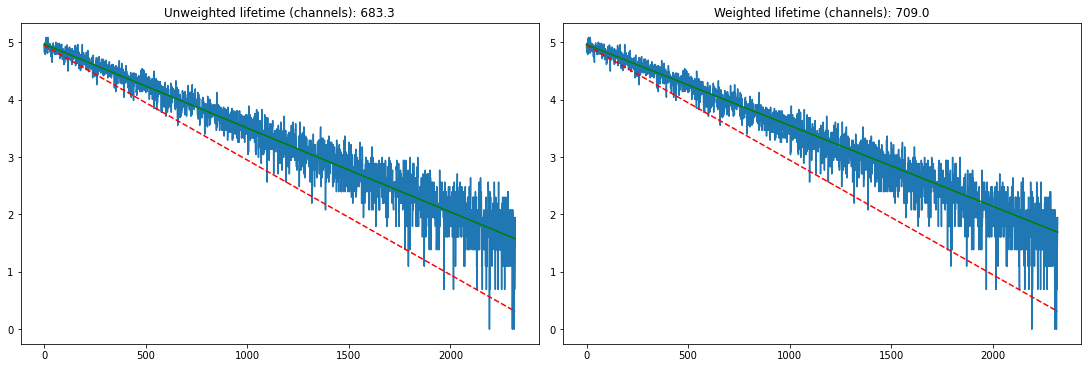

Fitted lifetime (channels): 709.0


In [16]:
N = 100000  # 100000 will illustrate.  Use 10M to refine the model
k = 1/700  # 700 is the nominal mean lifetime (in channels) for full scale = 50000 ns
tr = -(1/k)*np.log(1-np.random.random((N,)))
bins = np.arange(0,16384)
hist, bins = np.histogram(tr, bins)  # arrange these N numbers by time:  shortest to longest
#print(hist[0][:700])
print(hist.sum())
fig, ax = plt.subplots()
ax.plot(bins[:-1],hist,',b')
plt.show()

#fit
from scipy.optimize import curve_fit
logHist = np.log(hist)  # this will produce some -inf when the values go to 0
chopRight = np.where (logHist == -np.inf)[0][0] # locate them and truncate the plot
print(chopRight)  # find first occurence of -inf in order to chop on right side

fig, ax = plt.subplots()
ax.plot(bins[:-1],logHist)
plt.show()
#chopRight = 5000
p0 = (logHist[0], -1/500)
def func_lin(t,p0, p1):
    return p0+p1*t
logHist_chopped = logHist[:chopRight]
bins_chopped = bins[:chopRight]
fig, axs = plt.subplots(1,2, figsize = (15,5),constrained_layout = True)
axs[0].set_title("Unweighted")
axs[0].plot(bins_chopped,logHist_chopped)
popt, pcov = curve_fit(func_lin, bins_chopped, logHist_chopped, p0)
axs[0].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[0].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Unweighted lifetime (channels): {:5.1f}".format(-1/popt[1])
axs[0].set_title(title)

axs[1].plot(bins_chopped,logHist_chopped)


sigmas = 1/np.sqrt(hist[:chopRight])
popt, pcov = curve_fit(func_lin, bins_chopped, logHist_chopped, p0, sigma = sigmas)
axs[1].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[1].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Weighted lifetime (channels): {:5.1f}".format(-1/popt[1])
axs[1].set_title(title)
plt.show()
print("Fitted lifetime (channels): {:5.1f}".format(-1/popt[1]))

### If we sacrifice some time resolution we can reduce the uncertainty in the number of counts.  We do this by adding groups of channels together (thus increasing aggregate N):

16383
16384
512 512
100000


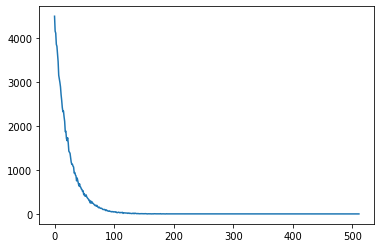

ChopRight, 156


C:\Users\alexh\AppData\Local\Temp/ipykernel_6292/2574627934.py:31: RuntimeWarning: divide by zero encountered in log
  logHist32 = np.log(hist32)


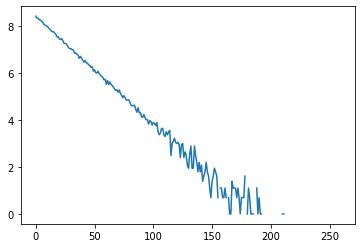

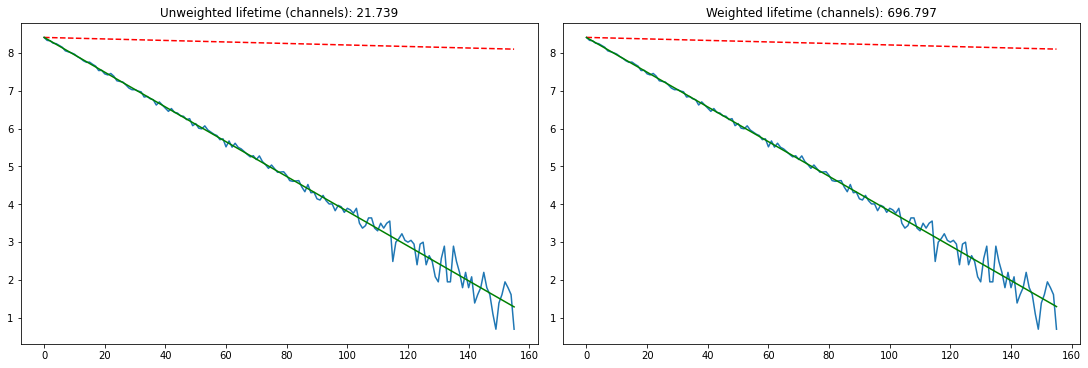

Weighted lifetime (channels): 696.797


In [17]:
## Explore the effect of binning the data in order to improve count statistics while sacrificing time resolution

print(len(hist))

# Need to pad it because we want 2^14 points
hist2 = np.pad(hist,(0,1))  # pad it to get multiple of 2
print(len(hist2))

hist3 = hist2.reshape(-1,32)  # make it 32 across
#print(hist3)
hist32 = hist2.reshape(-1,32).sum(axis = 1)  # add across the 32 columns, improving the N stats by sqrt(32)

#print(hist32)

# N = 10000
# k = 1/700
# tr = -(1/k)*np.log(1-np.random.random((N,)))
# bins = np.arange(0,16384)
# hist, bins = np.histogram(tr, bins)

bins = np.arange(0,16384/32)
print(len(hist32), len(bins))
#print(hist[0][:700])
print(hist32.sum())
fig, ax = plt.subplots()
ax.plot(bins,hist32)
plt.show()

#fit
from scipy.optimize import curve_fit
logHist32 = np.log(hist32)
chopRight = np.where (logHist32 == -np.inf)[0][0]
print(f"ChopRight, {chopRight}")  # find first occurence of -inf in order to chop on right side

fig, ax = plt.subplots()
ax.plot(bins,logHist32)
plt.show()
#chopRight = 5000
p0 = (logHist32[0], -1/500)
def func_lin(t,p0, p1):
    return p0+p1*t
logHist32_chopped = logHist32[:chopRight]
bins_chopped = bins[:chopRight]
fig, axs = plt.subplots(1,2, figsize = (15,5),constrained_layout = True)
axs[0].set_title("Unweighted")
axs[0].plot(bins_chopped,logHist32_chopped)
popt, pcov = curve_fit(func_lin, bins_chopped, logHist32_chopped, p0)
axs[0].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[0].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Unweighted lifetime (channels): {:5.3f}".format(-1/popt[1])
axs[0].set_title(title)

axs[1].plot(bins_chopped,logHist32_chopped)


sigmas = 1/np.sqrt(hist[:chopRight])
popt, pcov = curve_fit(func_lin, bins_chopped, logHist32_chopped, p0, sigma = sigmas)
axs[1].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[1].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Weighted lifetime (channels): {:5.3f}".format(-32/popt[1])
axs[1].set_title(title)
plt.show()
print("Weighted lifetime (channels): {:5.3f}".format(-32/popt[1]))

### Using NumPy's canned exponential distribution

100000


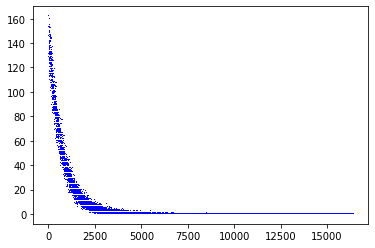

2461


C:\Users\alexh\AppData\Local\Temp/ipykernel_6292/1799688035.py:19: RuntimeWarning: divide by zero encountered in log
  logHist = np.log(hist)  # this will produce some -inf when the values go to 0


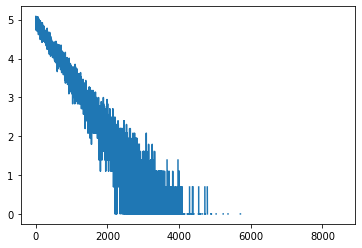

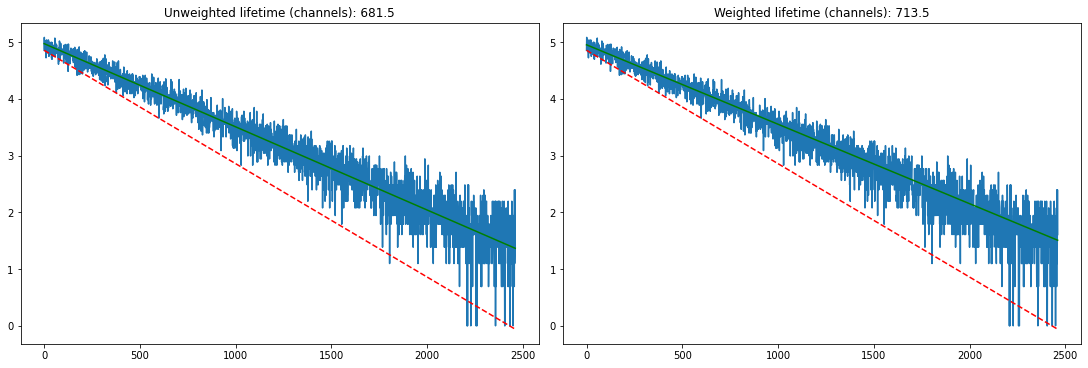

Fitted lifetime (channels): 713.5


In [4]:
#  Our home-built exponential distribution is pretty good, but there is a faster one in python as well
from numpy.random import default_rng  # the Generator
rng = default_rng()
k = 1/700
N = 100000
vals = rng.exponential(1/k,N)  # the exponential method

bins = np.arange(0,16384)
hist, bins = np.histogram(vals, bins)
#print(hist[0][:700])
print(hist.sum())  # proof that we've accounted for all of them
fig, ax = plt.subplots()
ax.plot(bins[:-1],hist,',b')
plt.show()


#fit
from scipy.optimize import curve_fit
logHist = np.log(hist)  # this will produce some -inf when the values go to 0
chopRight = np.where (logHist == -np.inf)[0][0] # locate them and truncate the plot
print(chopRight)  # find first occurence of -inf in order to chop on right side

fig, ax = plt.subplots()
ax.plot(bins[:-1],logHist)
plt.show()
#chopRight = 5000
p0 = (logHist[0], -1/500)
def func_lin(t,p0, p1):
    return p0+p1*t
logHist_chopped = logHist[:chopRight]
bins_chopped = bins[:chopRight]
fig, axs = plt.subplots(1,2, figsize = (15,5),constrained_layout = True)
axs[0].set_title("Unweighted")
axs[0].plot(bins_chopped,logHist_chopped)
popt, pcov = curve_fit(func_lin, bins_chopped, logHist_chopped, p0)
axs[0].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[0].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Unweighted lifetime (channels): {:5.1f}".format(-1/popt[1])
axs[0].set_title(title)

axs[1].plot(bins_chopped,logHist_chopped)


sigmas = 1/np.sqrt(hist[:chopRight])
popt, pcov = curve_fit(func_lin, bins_chopped, logHist_chopped, p0, sigma = sigmas)
axs[1].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[1].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Weighted lifetime (channels): {:5.1f}".format(-1/popt[1])
axs[1].set_title(title)
plt.show()
print("Fitted lifetime (channels): {:5.1f}".format(-1/popt[1]))

###  Let's compare speed and averages of the two methods

In [5]:
import timeit

In [6]:
%%timeit

#  Home built

N = 100000
k = 1/700
tr = -(1/k)*np.log(1-np.random.random((N,)))  # this is the old procedure
#bins = np.arange(0,16384)
#hist, bins = np.histogram(tr, bins)
#print(hist[0][:700])
#print(hist.sum(), hist.mean())

1.67 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%%timeit
rng = default_rng()
k = 1/700
N = 100000
vals = rng.exponential(k,N)

#bins = np.arange(0,16384)
#hist, bins = np.histogram(vals, bins)
#print(hist[0][:700])
#print(hist.sum(), hist.mean())  # proof that we've accounted for all of them


832 µs ± 63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%%timeit
N = 100000
k = 1/700
rng = default_rng()
tr = -(1/k)*np.log(1-rng.random((N,)))  # new procedure with Generator
# bins = np.arange(0,16384)
# hist, bins = np.histogram(tr, bins)
#print(hist[0][:700])
#print(hist.sum(), hist.mean())

1.83 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The canned routine is about 2x as fast as our homebuilt version when using the same Generator

### Now that you have the basics of simulating random muon lifetime decays, try these variations:

    Add random noise to the baseline, filling all channels of the histogram (i.e., MCA) with a few random counts
        figure out a way to subtract these off while fitting
        
    Consider that we use a carbon-containing scintillator that causes some fraction of the negative muons to be captured by the nuclei in the scintillator.  These muons will not produce a decay electron and so we will not detect them.  You'll need to look up the lifetime of negative muons (Suzuki, et al.) in matter.  
    Assume that the carbon capture dominates over the hydrogen.  So now you have two known lifetimes:  $\mu_+$ and $\mu_-$.
    
    Look up the  $\mu_+$ : $\mu_-$ ratio at sea-level.  Now create a model such that the spectrum you observe is due to the sum of the *rates* of decay of the two populations, in proportion to their populations.  This will reduce your measured lifetime by some few percent.

### Here we are measuring time in nanoseconds, not MCA bins

In [1]:
ratio = 1.2766
frac_plus = ratio/(1+ratio)
frac_minus = 1/(1+ratio)
print(frac_plus, frac_minus)

0.5607484845822718 0.43925151541772817


In [2]:
tau_plus = 2197.03
tau_minus = 2020

mixed_tau = 1/(frac_plus/tau_plus + frac_minus/tau_minus)
print ("Modeled weighted lifetime of pos and neg muons: {:5.2f} ns".format(mixed_tau))

Modeled weighted lifetime of pos and neg muons: 2115.59 ns


In [3]:
muon_expected_frac = mixed_tau/tau_plus
print(muon_expected_frac)

0.9629315698730381


1682476
2998638 183.03351034609045
16383
2998638


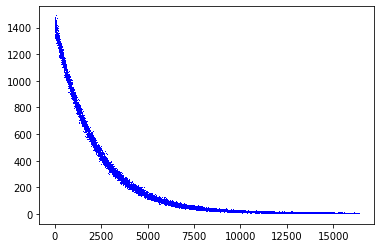

11713


C:\Users\alexh\AppData\Local\Temp/ipykernel_6292/2915635743.py:29: RuntimeWarning: divide by zero encountered in log
  logHist = np.log(hist)  # this will produce some -inf when the values go to 0


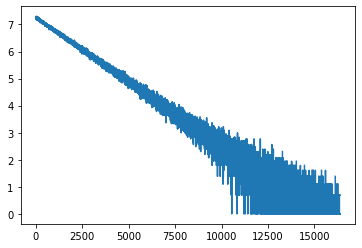

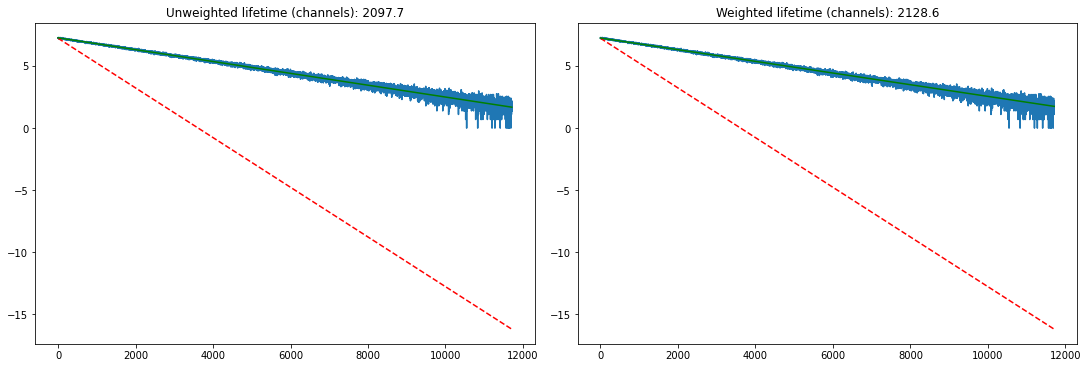

Fitted lifetime (channels): 2128.6
16384
[[1390 1457 1456 ... 1399 1394 1437]
 [1374 1331 1389 ... 1377 1392 1262]
 [1302 1319 1287 ... 1244 1342 1297]
 ...
 [   0    0    3 ...    0    0    0]
 [   0    0    0 ...    1    1    0]
 [   2    0    1 ...    2    2    0]]
[89707 86727 84073 81290 78905 76969 74606 72614 70083 67857 65631 64066
 62341 60140 58337 56590 54950 53537 51613 50238 48721 47810 45860 44667
 43802 41782 40657 39413 38073 37343 35959 35084 33766 32815 32026 30845
 30113 28931 28170 27647 26600 25480 24928 24296 23698 22749 22034 21765
 20941 20246 19754 19192 18424 18142 17440 16960 16618 15840 15343 15038
 14785 13994 13868 13154 12909 12540 12094 11837 11383 11177 10867 10516
 10205  9891  9529  9410  8951  8723  8254  8220  7959  7764  7614  7220
  7109  6806  6481  6458  6404  6090  5902  5724  5600  5301  5159  4947
  4819  4874  4603  4608  4303  4279  4014  3948  3904  3729  3726  3516
  3433  3235  3287  3155  3036  3013  2840  2732  2715  2526  2536  2483
 

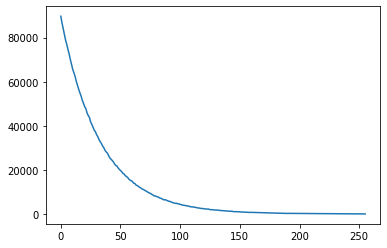

-1


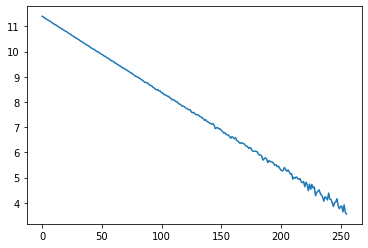

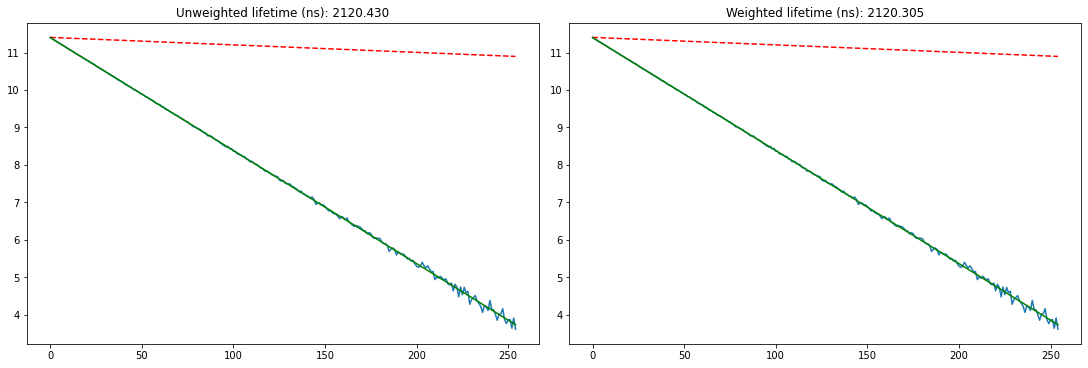

Weighted lifetime (ns): 2120.305


In [12]:
#  Mixed spectrum
import numpy as np
N = 3000000  # 
Np = int(N*frac_plus)
print(Np)
Nn = int(N*frac_minus)
kp = 1/tau_plus
kn = 1/tau_minus

rng = default_rng()
valsp = rng.exponential(1/kp,Np)
valsn = rng.exponential(1/kn,Nn)
vals = np.append(valsp,valsn)
bins = np.arange(0,16384)
hist, bins = np.histogram(vals, bins)

#print(hist[0][:700])
print(hist.sum(), hist.mean())  # proof that we've accounted for all of them
print(len(hist))

print(hist.sum())  # proof that we've accounted for all of them
fig, ax = plt.subplots()
ax.plot(bins[:-1],hist,',b')
plt.show()


#fit
from scipy.optimize import curve_fit
logHist = np.log(hist)  # this will produce some -inf when the values go to 0
try:
    chopRight = np.where (logHist == -np.inf)[0][0] # locate them and truncate the plot
except:
    chopRight = -2
print(chopRight)  # find first occurence of -inf in order to chop on right side

fig, ax = plt.subplots()
ax.plot(bins[:-1],logHist)
plt.show()
#chopRight = 5000
p0 = (logHist[0], -1/500)
def func_lin(t,p0, p1):
    return p0+p1*t
logHist_chopped = logHist[:chopRight]
bins_chopped = bins[:chopRight]
fig, axs = plt.subplots(1,2, figsize = (15,5),constrained_layout = True)
axs[0].set_title("Unweighted")
axs[0].plot(bins_chopped,logHist_chopped)
popt, pcov = curve_fit(func_lin, bins_chopped, logHist_chopped, p0)
axs[0].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[0].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Unweighted lifetime (channels): {:5.1f}".format(-1/popt[1])
axs[0].set_title(title)

axs[1].plot(bins_chopped,logHist_chopped)


sigmas = 1/np.sqrt(hist[:chopRight])
popt, pcov = curve_fit(func_lin, bins_chopped, logHist_chopped, p0, sigma = sigmas)
axs[1].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[1].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Weighted lifetime (channels): {:5.1f}".format(-1/popt[1])
axs[1].set_title(title)
plt.show()
print("Fitted lifetime (channels): {:5.1f}".format(-1/popt[1]))



# Need to pad it because we want 2^14 points
hist2 = np.pad(hist,(0,1))  # pad it to get multiple of 2
print(len(hist2))
#hist2 = hist
nsum = 64
hist3 = hist2.reshape(-1,nsum)  # make it nsum across
print(hist3)
histnsum = hist2.reshape(-1,nsum).sum(axis = 1)  # add across the columns, improving the N stats by sqrt(nsum)

print(histnsum)
hist = histnsum
bins = np.arange(0,16384/nsum)
print(len(hist), len(bins))
#print(hist[0][:700])
print(hist.sum())
fig, ax = plt.subplots()
ax.plot(bins,hist)
plt.show()

#fit
from scipy.optimize import curve_fit
logHist = np.log(hist)
try:
    chopRight = np.where (logHist == -np.inf)[0][0]
except:
    chopRight = -1
print(chopRight)  # find first occurence of -inf in order to chop on right side

fig, ax = plt.subplots()
ax.plot(bins,logHist)
plt.show()
#chopRight = 5000
p0 = (logHist[0], -1/500)
def func_lin(t,p0, p1):
    return p0+p1*t
logHist_chopped = logHist[:chopRight]
bins_chopped = bins[:chopRight]
fig, axs = plt.subplots(1,2, figsize = (15,5),constrained_layout = True)
axs[0].set_title("Unweighted")
axs[0].plot(bins_chopped,logHist_chopped)
popt, pcov = curve_fit(func_lin, bins_chopped, logHist_chopped, p0)
axs[0].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[0].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Unweighted lifetime (ns): {:5.3f}".format(-1/popt[1]*nsum)
axs[0].set_title(title)

axs[1].plot(bins_chopped,logHist_chopped)


sigmas = 1/np.sqrt(hist[:chopRight])
popt, pcov = curve_fit(func_lin, bins_chopped, logHist_chopped, p0, sigma = sigmas)
axs[1].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[1].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Weighted lifetime (ns): {:5.3f}".format(-1/popt[1]*nsum)
axs[1].set_title(title)
plt.show()
print("Weighted lifetime (ns): {:5.3f}".format(-1/popt[1]*nsum))

### More realistically, there are random hits of muon pairs that fill channels with background.  So we repeat the above steps but with a random background , maybe 1.5 counts per channel

10024650.0


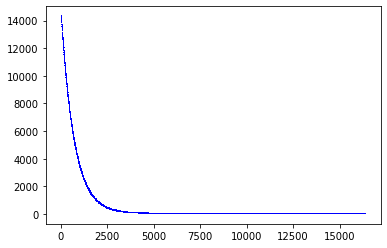

C:\Users\alexh\AppData\Local\Temp/ipykernel_6292/1876682689.py:15: RuntimeWarning: divide by zero encountered in log
  logHist = np.log(hist)  # this will produce some -inf when the values go to 0


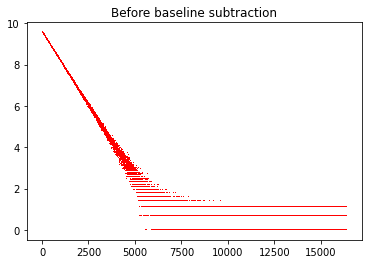

average baseline: 1.505
5554


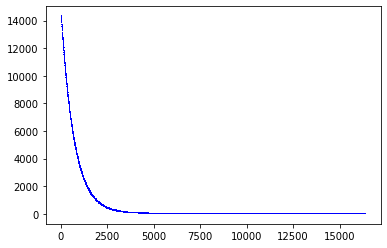

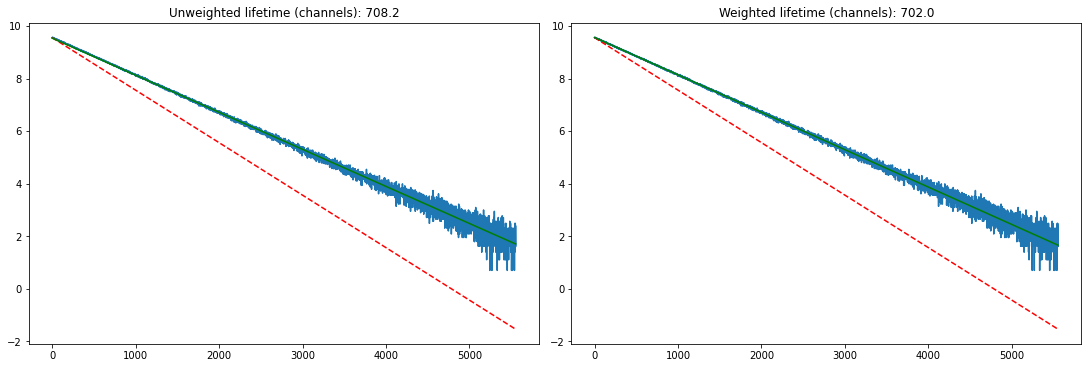

Fitted lifetime (channels): 702.0


In [13]:
N = 10000000
b = 1.5  # background
k = 1/700  # 700 is the typical mean lifetime (in channels) for full scale = 50000 ns
tr = -(1/k)*np.log(1-np.random.random((N,))) 
bins = np.arange(0,16384)
hist, bins = np.histogram(tr, bins)  # arrange these N numbers by time:  shortest to longest
# Now add in the random background to the histogram
hist = hist+np.round(2*b*np.random.random(16383))  # add the random background

#print(hist[0][:700])
print(hist.sum())
fig, ax = plt.subplots()
ax.plot(bins[:-1],hist,',b')
plt.show()
logHist = np.log(hist)  # this will produce some -inf when the values go to 0

fig, ax = plt.subplots()

ax.plot(bins[:-1],logHist,',r')
ax.set_title("Before baseline subtraction")
plt.show()

# find baseline from last 1000 channels
baseline = hist[-1000:].mean()
print("average baseline:",baseline)
hist = hist - baseline*np.ones(16383)

# remove all values after you get no counts anywhere
chopRight = np.where(hist <=0)[0][0]
print(chopRight) 
fig, ax = plt.subplots()
ax.plot(bins[:-1],hist,',b')
plt.show()




#fit
from scipy.optimize import curve_fit






#chopRight = np.where (logHist == -np.inf)[0][0] # locate them and truncate the plot
#print(chopRight)  # find first occurence of -inf in order to chop on right side

# fig, ax = plt.subplots()
# ax.plot(bins[:-1],logHist)
# plt.show()
#chopRight = 5000
p0 = (logHist[0], -1/500)
def func_lin(t,p0, p1):
    return p0+p1*t
logHist_chopped = logHist[:chopRight]
bins_chopped = bins[:chopRight]
fig, axs = plt.subplots(1,2, figsize = (15,5),constrained_layout = True)
axs[0].set_title("Unweighted")
axs[0].plot(bins_chopped,logHist_chopped)
popt, pcov = curve_fit(func_lin, bins_chopped, logHist_chopped, p0)
axs[0].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[0].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Unweighted lifetime (channels): {:5.1f}".format(-1/popt[1])
axs[0].set_title(title)

axs[1].plot(bins_chopped,logHist_chopped)


sigmas = 1/np.sqrt(hist[:chopRight])
popt, pcov = curve_fit(func_lin, bins_chopped, logHist_chopped, p0, sigma = sigmas)
axs[1].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[1].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Weighted lifetime (channels): {:5.1f}".format(-1/popt[1])
axs[1].set_title(title)
plt.show()
print("Fitted lifetime (channels): {:5.1f}".format(-1/popt[1]))

16383
16384
512 512
9999993.585000006


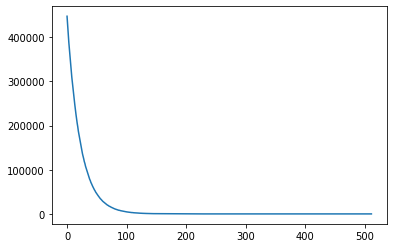

chopRight:  245
245


C:\Users\alexh\AppData\Local\Temp/ipykernel_6292/4019645473.py:31: RuntimeWarning: invalid value encountered in log
  logHist32 = np.log(hist32)


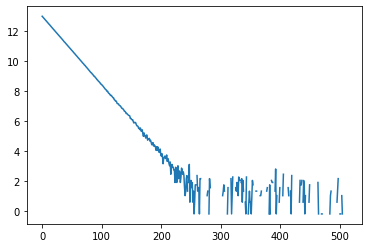

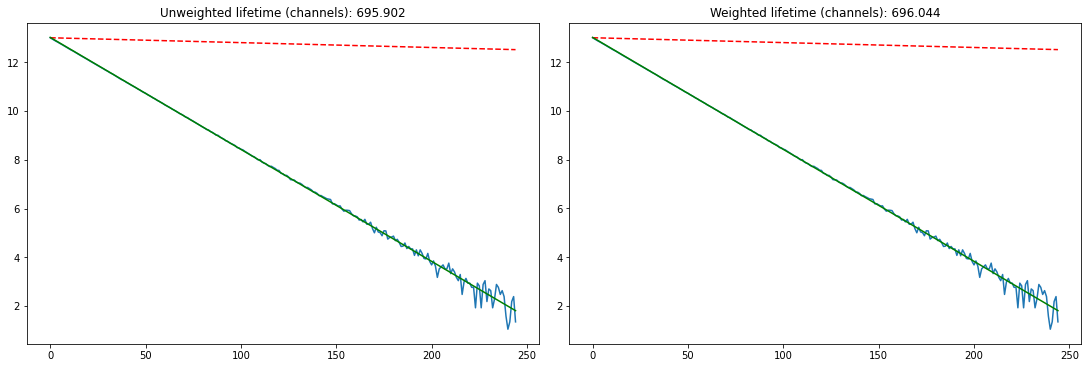

Weighted lifetime (channels): 696.044


In [14]:
## Explore the effect of binning the data in order to improve count statistics while sacrificing time resolution

print(len(hist))

# Need to pad it because we want 2^14 points
hist2 = np.pad(hist,(0,1))  # pad it to get multiple of 2
print(len(hist2))

hist3 = hist2.reshape(-1,32)  # make it 32 across
#print(hist3)
hist32 = hist2.reshape(-1,32).sum(axis = 1)  # add across the 32 columns, improving the N stats by sqrt(32)

#print(hist32)

# N = 10000
# k = 1/700
# tr = -(1/k)*np.log(1-np.random.random((N,)))
# bins = np.arange(0,16384)
# hist, bins = np.histogram(tr, bins)

bins = np.arange(0,16384/32)
print(len(hist32), len(bins))
#print(hist[0][:700])
print(hist32.sum())
fig, ax = plt.subplots()
ax.plot(bins,hist32)
plt.show()

#fit
from scipy.optimize import curve_fit
logHist32 = np.log(hist32)
try:
    keep = np.where(np.isfinite(logHist32), logHist32, 0)
    chopRight = np.where (keep == 0)[0][0]
    print("chopRight: ", chopRight)
except: 
    chopRight = -1
print(chopRight)  # find first occurence of -inf in order to chop on right side

fig, ax = plt.subplots()
ax.plot(bins,logHist32)
plt.show()
#chopRight = 5000
p0 = (logHist32[0], -1/500)
def func_lin(t,p0, p1):
    return p0+p1*t
logHist32_chopped = logHist32[:chopRight]
bins_chopped = bins[:chopRight]
fig, axs = plt.subplots(1,2, figsize = (15,5),constrained_layout = True)
axs[0].set_title("Unweighted")
axs[0].plot(bins_chopped,logHist32_chopped)
popt, pcov = curve_fit(func_lin, bins_chopped, logHist32_chopped, p0)
axs[0].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[0].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Unweighted lifetime (channels): {:5.3f}".format(-32/popt[1])
axs[0].set_title(title)

axs[1].plot(bins_chopped,logHist32_chopped)


sigmas = 1/np.sqrt(hist[:chopRight])
popt, pcov = curve_fit(func_lin, bins_chopped, logHist32_chopped, p0, sigma = sigmas)
axs[1].plot(bins_chopped,func_lin(bins_chopped,*p0), '--r')
axs[1].plot(bins_chopped,func_lin(bins_chopped,*popt), '-g')
title = "Weighted lifetime (channels): {:5.3f}".format(-32/popt[1])
axs[1].set_title(title)
plt.show()
print("Weighted lifetime (channels): {:5.3f}".format(-32/popt[1]))